# Model for the Concentration Dynamics in Mixed-Species Liquid Cell Cultures

## Setup

In [1]:
import concentration_dynamics

In [2]:
ode_system = concentration_dynamics.suspended_cultures_ode()
assert ode_system.load_reaction_params("constants.yml") , "Failed to load reaction parameters from constants.yml"
assert ode_system.load_gas_exchange_params("constants.yml", "parameters.yml"), "Failed to load gas exchange parameters"

initial_state = concentration_dynamics.make_initial_state("initial_conditions.yml")
assert initial_state is not None , "Failed to load initial state from file."
initial_state = concentration_dynamics.update_state_with_gas_at_equilibrium(initial_state, ode_system)

In [3]:
initial_state

[0.03,
 0.01,
 np.float64(0.013495140485951407),
 np.float64(0.27232271535346464),
 np.float64(0.00014084175000000001),
 70.0,
 100.0,
 10.0]

In [4]:
ode_system(None, initial_state)

[np.float64(2.462906978425879e-07),
 np.float64(1.300317036057582e-11),
 np.float64(-1.829453619161012e-07),
 np.float64(4.1292133906312784e-07),
 np.float64(-2.5006096847261192e-11),
 0.0,
 np.float64(-2.6682818841835745e-08),
 np.float64(-2.4630370101294847e-09)]

In [5]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp


In [6]:
# time span for the simulation
t_span = (0, 2*356*24*3600)  # 2 years in seconds
#t_span = (0, 18*7*24*3600)  # 4 weeks in seconds
#t_span = (0, 24*3600)  # 1 day in seconds
#t_span = (0, 3600)  # 1 hour in seconds
#t_span = (0, 2)  # 2 seconds

# solve the ODE system
sol = solve_ivp(
    ode_system, 
    t_span, 
    initial_state, 
    method='RK45', 
    t_eval=np.linspace(t_span[0], t_span[1], num=10000), 
    events=concentration_dynamics.IVP_SOLUTION_TERMINATION_EVENTS 
)

NameError: name 'consumption_rates' is not defined

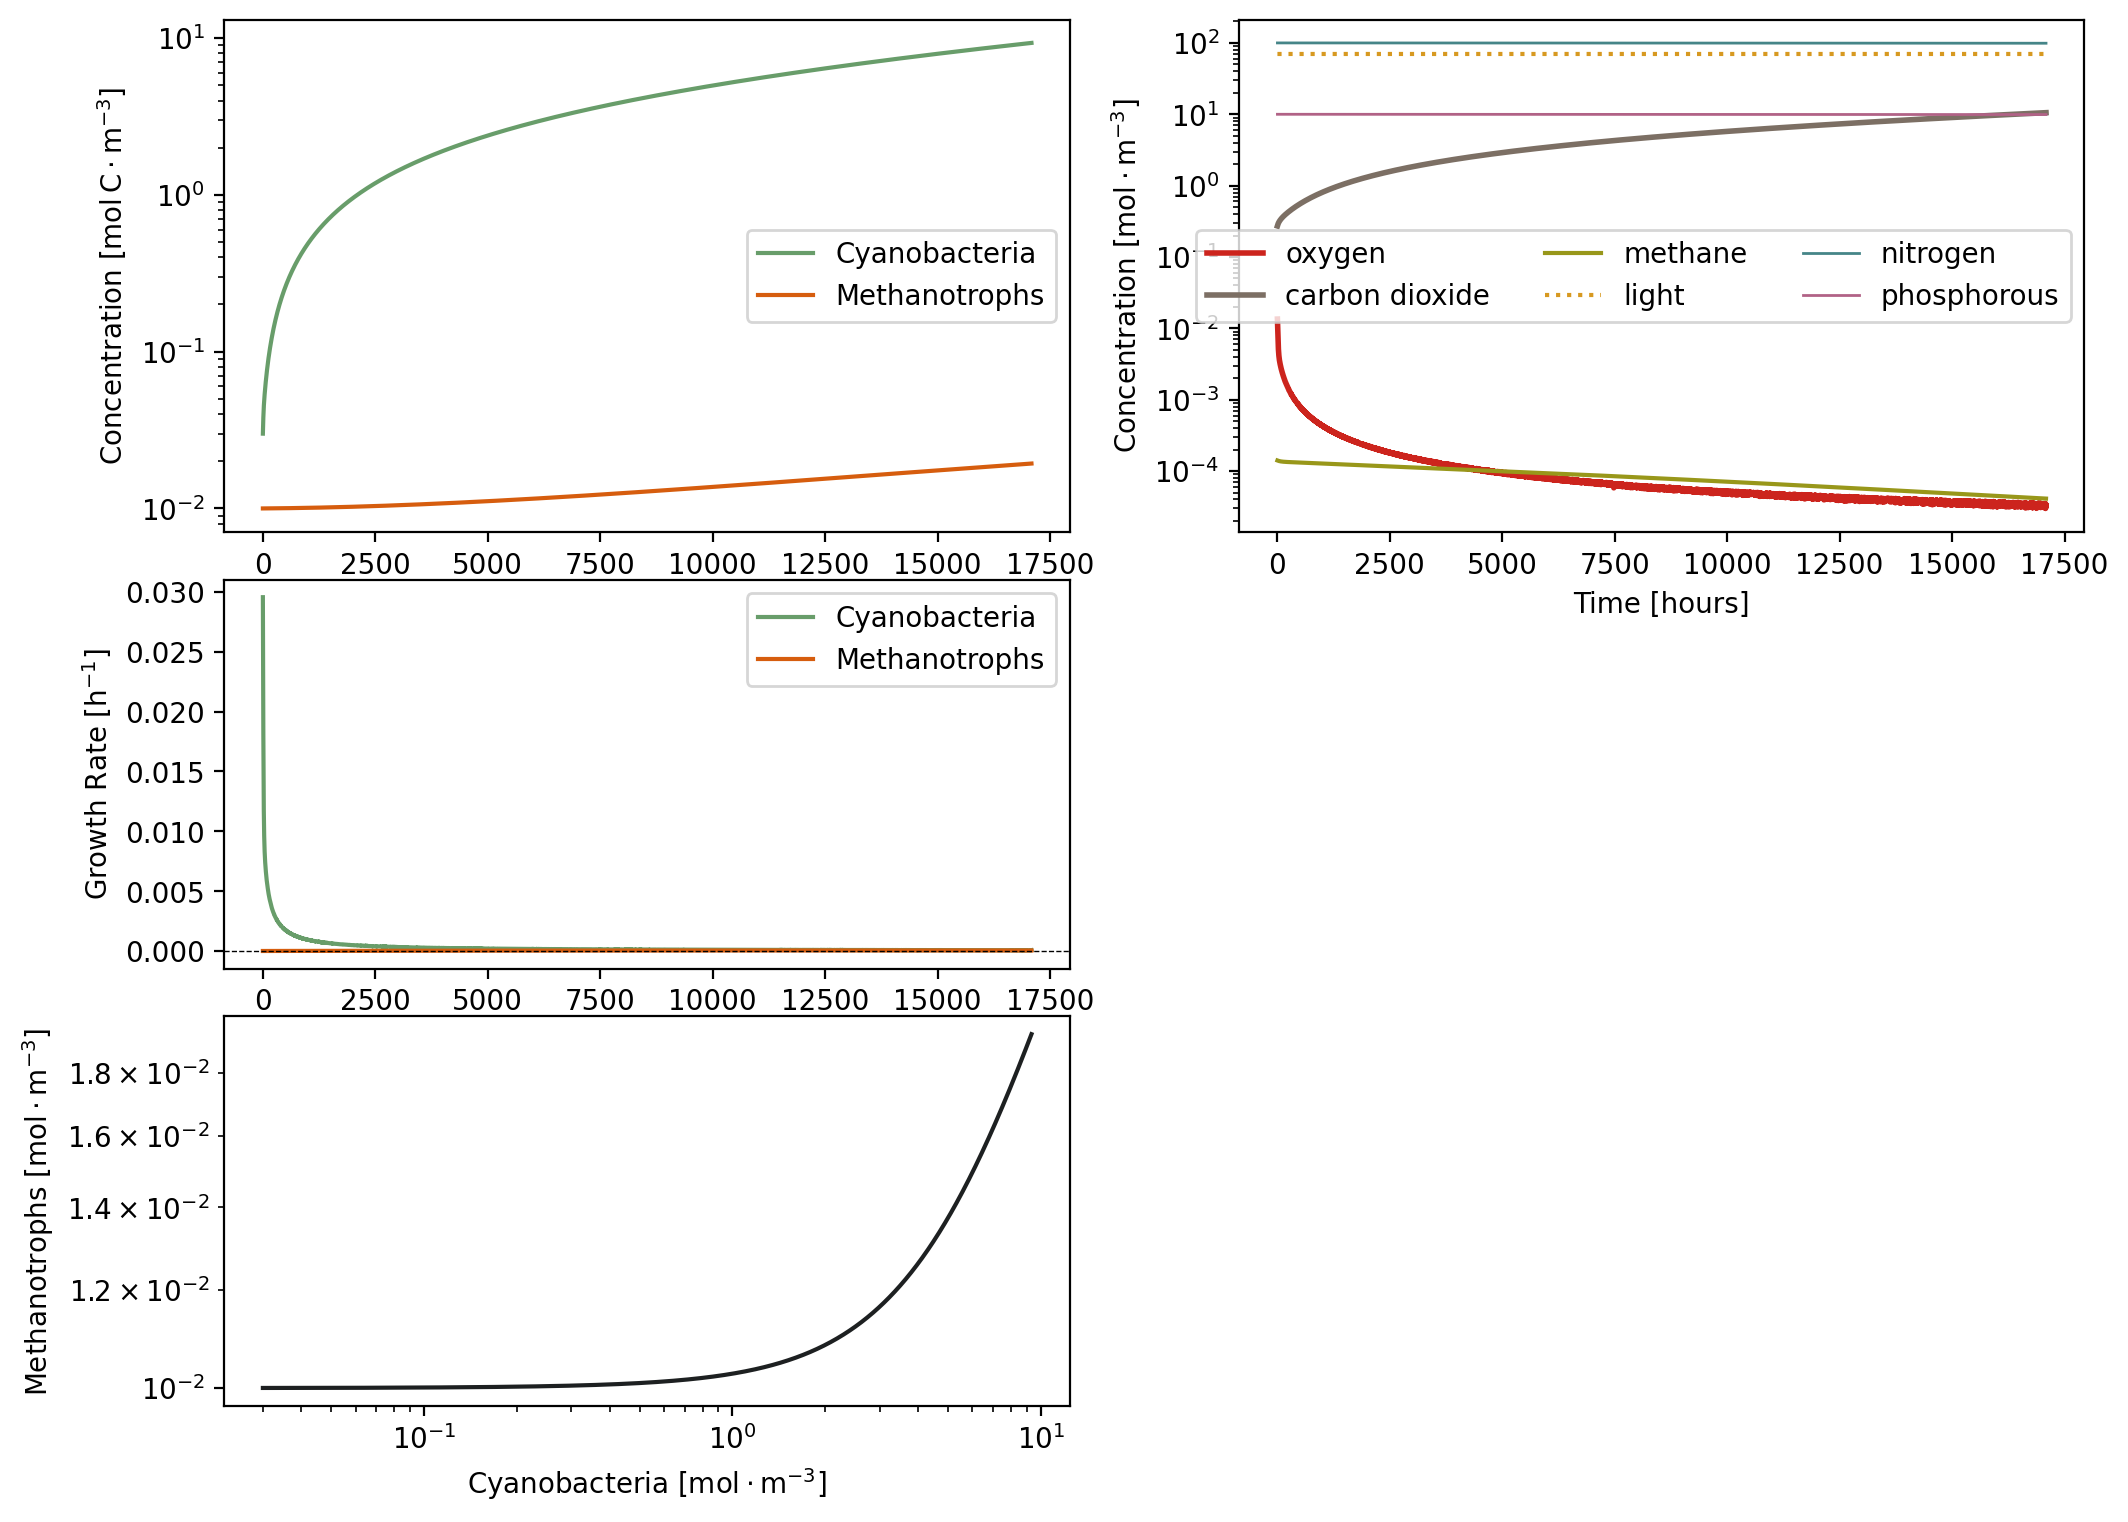

In [7]:
# Plot the results:
# left: Concentrations of Cyanobacteria (cyan: #689d6a) and Methanotrophs (orange: #d65d0e) over time.
# middle: Concentrations of oxygen (red: #cc241d), carbon dioxide (gray: #7c6f64) and methane (purple: #b16286) over time.
# right: Trajectory of the system in the concentration space of Cyanobacteria (x) and Methanotrophs (y).

fig = plt.figure( figsize=(12,9), dpi=200 )
axs = fig.add_gridspec( 5, 2, height_ratios=[3,1,1,1,1] )

ax = fig.add_subplot( axs[0,0] )
ax.plot(sol.t / 3600, sol.y[0], label='Cyanobacteria', color='#689d6a')
ax.plot(sol.t / 3600, sol.y[1], label='Methanotrophs', color='#d65d0e')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\,\mathrm{C}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend()

ax = fig.add_subplot( axs[1:3,0] )
growth_rates = np.array( [ ode_system._mu(*state) for state in sol.y.T ] ).T
ax.plot(sol.t / 3600, 3600*growth_rates[0], label='Cyanobacteria', color='#689d6a')
ax.plot(sol.t / 3600, 3600*growth_rates[1], label='Methanotrophs', color='#d65d0e')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Growth Rate $\left[\mathrm{h}^{-1}\\right]$')
ax.legend()

ax = fig.add_subplot( axs[3:5,0] )
ax.plot(sol.y[0], sol.y[1], color='#1d2021')
ax.set_xlabel('Cyanobacteria [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_ylabel('Methanotrophs [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_xscale("log")
ax.set_yscale("log")


ax = fig.add_subplot( axs[0,1] )
ax.plot(sol.t / 3600, sol.y[2], label='oxygen', color='#cc241d', lw=2)
ax.plot(sol.t / 3600, sol.y[3], label='carbon dioxide', color='#7c6f64', lw=2)
ax.plot(sol.t / 3600, sol.y[4], label='methane', color='#98971a', lw=1.5)
ax.plot(sol.t / 3600, sol.y[5], label='light', color='#d79921', lw=1.5, ls=':')
ax.plot(sol.t / 3600, sol.y[6], label='nitrogen', color='#458588', lw=1)
ax.plot(sol.t / 3600, sol.y[7], label='phosphorous', color='#b16286', lw=1)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend(ncols=3)

y_consumption_rates = np.array( [ consumption_rates(FIXED_PARAMS["inverse_yields"], (pCy,pMe)) for pCy,pMe in zip( growth_rates[0]*sol.y[0], growth_rates[1]*sol.y[1] ) ] ).T
y_production_rates = np.array( [ production_rates(FIXED_PARAMS["alpha"], FIXED_PARAMS["beta"], (Cy, Me), (pCy*Cy,pMe*Me)) for Cy,Me,pCy,pMe in zip( sol.y[0], sol.y[1], growth_rates[0], growth_rates[1] ) ] ).T
y_exchange_rates = np.array( 
    [ 
        gas_exchange_rates(
            FIXED_PARAMS["k_La"], { chem : ADJUSTABLE_PARAMS["p"][chem]/FIXED_PARAMS["H"][chem] for chem in ("O2", "CO2", "CH4") }, 
            (c_O2, c_CO2, c_CH4)
        ) for c_O2, c_CO2, c_CH4 in zip( sol.y[2], sol.y[3], sol.y[4] ) 
    ] 
).T

ax = fig.add_subplot( axs[1,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[0], label='consumption', color='#cc241d', ls='--')
ax.plot(sol.t / 3600, 3600*y_production_rates[0], label='production', color='#cc241d')
ax.plot(sol.t / 3600, 3600*y_production_rates[0], label='exchange', color='#cc241d', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{O}_2$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=3)

ax = fig.add_subplot( axs[2,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[1], label='consumption', color='#7c6f64', ls='--')
ax.plot(sol.t / 3600, 3600*y_production_rates[1], label='production', color='#7c6f64')
ax.plot(sol.t / 3600, 3600*y_production_rates[1], label='exchange', color='#7c6f64', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{CO}_2$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=3)

ax = fig.add_subplot( axs[3,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[2], label='consumption', color='#98971a', ls='--')
ax.plot(sol.t / 3600, 3600*y_consumption_rates[2], label='exchange', color='#98971a', ls=':')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{CH}_4$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.set_xticklabels([])
ax.legend(ncols=2)

ax = fig.add_subplot( axs[4,1] )
ax.plot(sol.t / 3600, 3600*y_consumption_rates[3], label='$\mathrm{N}$ consumption', color='#458588', ls='--')
ax.plot(sol.t / 3600, 3600*y_consumption_rates[4], label='$\mathrm{P}$ consumption', color='#b16286', ls='--')
ax.axhline(0, c='k', lw=0.5, ls='--')
ax.set_ylabel('$\mathrm{N},\mathrm{P}$ Rate $\\left[ \\frac{ \mathrm{mol} }{ \mathrm{m}^{3}\cdot\mathrm{h} } \\right]$')
ax.legend(ncols=2)

ax.set_xlabel('Time [hours]')

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Dynamics v1.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )